In [2]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr
import rioxarray 
# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Other libraries (e.g. paths, filenames, zipfile extraction)
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile
import urllib3 
urllib3.disable_warnings() # Disable "InsecureRequestWarning" 

import altair as alt   
import os    
import geopandas as gpd
import matplotlib.dates as mdates
from pythia_datasets import DATASETS
import nc_time_axis

import seaborn as sns
import pandas as pd

In [3]:
DATADIR = '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/'

In [4]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '155787:7b63e83a-7b9b-4a71-92f9-faf8b5c0faa6'

# Download CORDEX Historical

In [69]:
c = cdsapi.Client(url=URL, key=KEY)

models = ['ichec_ec_earth','mohc_hadgem2_es','mpi_m_mpi_esm_mr','cnrm_cerfacs_cm5','ipsl_cm5a_lr']
variables = ['mean_precipitation_flux','2m_air_temperature']

for model in models:
    for var in variables:
        c.retrieve(
            'projections-cordex-domains-single-levels',
            {
                'format': 'zip',
                'domain': 'south_east_asia',
                'experiment': 'historical',
                'horizontal_resolution': '0_22_degree_x_0_22_degree',
                'temporal_resolution': 'daily_mean',
                'variable': '{}'.format(var),
                'gcm_model': '{}'.format(model),
                'rcm_model': 'ru_core_regcm4_3',
                'ensemble_member': 'r1i1p1',
                'start_year': ['1980', '1985', '1990', '1995','2000','2005'],
                'end_year': ['1984', '1989', '1994', '1999', '2004', '2005'],
            },
            f'{DATADIR}1980-2005_cordex_historical_south_east_asia_{model}_{var}.zip')

2022-11-13 19:10:02,831 INFO Welcome to the CDS
2022-11-13 19:10:02,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2022-11-13 19:10:03,063 INFO Request is queued
2022-11-13 19:10:04,244 INFO Request is running
2022-11-13 19:14:23,475 INFO Request is completed
2022-11-13 19:14:23,476 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data7/dataset-projections-cordex-domains-single-levels-254e9da3-b5b1-4d11-b595-405533ed39df.zip to /home/c4ubuntu/projDir/Indonesia/Data/CORDEX/1980-2005_cordex_historical_south_east_asia_ichec_ec_earth_mean_precipitation_flux.zip (1.3G)
2022-11-13 19:16:41,441 INFO Download rate 9.9M/s                                                     
2022-11-13 19:16:42,509 INFO Welcome to the CDS
2022-11-13 19:16:42,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2022-11-13 19:16:42,775 INFO

## Unzip

In [70]:
cordex_zip_paths = glob(f'{DATADIR}*.zip')

In [71]:
for j in cordex_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

# Precipitation

#### List

In [72]:
cordx_nc = list()
cordx_nc_rel = glob(f'{DATADIR}pr_*.nc')
for i in cordx_nc_rel:
    cordx_nc.append(os.path.basename(i))

In [73]:
cordx_nc

['pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19850101-19891231.nc',
 'pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19900101-19941231.nc',
 'pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19950101-19991231.nc',
 'pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19800101-19841231.nc',
 'pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20000101-20041231.nc',
 'pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20050101-20051231.nc',
 'pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19850101-19891230.nc',
 'pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20050101-20051130.nc',
 'pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19800101-19841230.nc',
 'pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19950101-19991230.nc',
 'pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_200001

#### Inspect

In [74]:
ds = xr.open_dataset(f'{DATADIR}{cordx_nc[1]}')
ds

<xarray.Dataset>
Dimensions:    (y: 191, x: 253, time: 1826, bnds: 2)
Coordinates:
    lat        (y, x) float64 ...
    lon        (y, x) float64 ...
  * time       (time) datetime64[ns] 1990-01-01T12:00:00 ... 1994-12-31T12:00:00
  * x          (x) float64 -3.15e+06 -3.125e+06 -3.1e+06 ... 3.125e+06 3.15e+06
  * y          (y) float64 -2.375e+06 -2.35e+06 ... 2.35e+06 2.375e+06
Dimensions without coordinates: bnds
Data variables:
    crs        |S1 ...
    pr         (time, y, x) float32 ...
    time_bnds  (time, bnds) datetime64[ns] ...
Attributes: (12/95)
    comment:                                    RegCM CORDEX Exp_04 run
    rcm_version_id:                             v4
    CORDEX_domain:                              SEA-22
    driving_experiment_name:                    historical
    institution:                                International Centre for Theo...
    driving_experiment:                         ICHEC-EC-EARTH, historical, r...
    ...                                         ...
    holtslag_critical_land_richardson:          0.25
    creation_date:                              2019-11-01-T12:59:48Z
    model_id:                                   RU-CORE-RegCM4-3
    institute_id:                               RU-CORE
    tracking_id:                                hdl:21.14103/e19dbbbc-4327-4b...
    c3s_disclaimer:                             This data has been curated an...

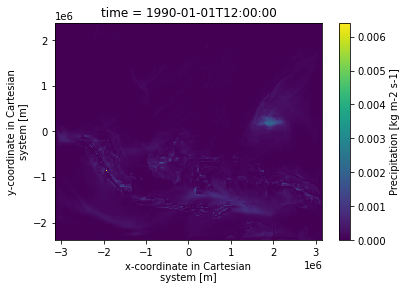

In [75]:
ds.pr[0].plot()

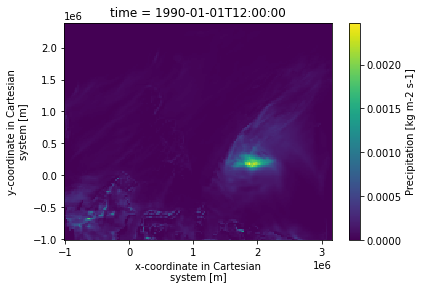

In [87]:
ds.sel(x = slice(-1000000, 11500000), y = slice(-1000000, 12500000)).pr[0].plot() #-1, 117, -11, 125

In [88]:
exp = ds.attrs['experiment_id']
mod = ds.attrs['driving_model_id']
mem = ds.attrs['driving_model_ensemble_member']
start = ds.attrs['model_simulation_start']
end = ds.attrs['model_simulation_end']

In [65]:
da = ds['pr']

In [41]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
da_weighted = da.weighted(weights)

In [42]:
da_weighted

DataArrayWeighted with weights along dimensions: y, x

In [43]:
da_agg = da_weighted.mean(['y', 'x'])

In [44]:
#da_yr = da_agg.groupby('time.month').mean()

da_yr = da_agg

In [45]:
da_yr = da_yr.assign_coords(model=mod)
da_yr = da_yr.expand_dims('model')
da_yr = da_yr.assign_coords(experiment=exp)
da_yr = da_yr.expand_dims('experiment')

In [46]:
da_yr

<xarray.DataArray 'pr' (experiment: 1, model: 1, time: 1826)>
array([[[6.66944050e-05, 7.84841621e-05, 9.78353595e-05, ...,
         5.64392367e-05, 6.17346516e-05, 5.73961384e-05]]])
Coordinates:
  * time        (time) datetime64[ns] 1990-01-01T12:00:00 ... 1994-12-31T12:0...
  * model       (model) <U21 'CNRM-CERFACS-CNRM-CM5'
  * experiment  (experiment) <U10 'historical'

### Aggregate for map

In [70]:
# Function to aggregate in geographical lat lon dimensions
def geog_agg_map(fn):
    ds = xr.open_dataset(f'{DATADIR}{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['driving_model_id']
    mem = ds.attrs['driving_model_ensemble_member']
    start = ds.attrs['model_simulation_start']
    end = ds.attrs['model_simulation_end']
    da = ds['pr']
    da_yr = da
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}/Maps/cordex_pr_day_agg_{mod}_{exp}_{}.nc')

In [71]:
cordx_nc = list()
cordx_nc_rel = glob(f'{DATADIR}pr_*.nc')
for i in cordx_nc_rel:
    
    cordx_nc.append(os.path.basename(i))

In [76]:
cordx_nc_rel.split()

['/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19900101-19941231.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20000101-20041231.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19800101-19841231.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20050101-20051231.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19850101-19891231.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19950101-19991231.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19800101-19841230.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/

In [73]:
for i in cordx_nc:
    try:
        geog_agg_map(i)
    except: print(f'{i} failed')

pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19900101-19941231.nc failed
pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20000101-20041231.nc failed
pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19800101-19841231.nc failed
pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20050101-20051231.nc failed
pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19850101-19891231.nc failed
pr_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19950101-19991231.nc failed
pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19800101-19841230.nc failed
pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19950101-19991230.nc failed
pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20050101-20051130.nc failed
pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20000101-20041230.nc failed
pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU

### Aggregate

In [606]:
# Function to aggregate in geographical lat lon dimensions
def geog_agg(fn):
    ds = xr.open_dataset(f'{DATADIR}{fn}')
    #ds = ds.convert_calendar("noleap")
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['driving_model_id']
    da = ds['pr']
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['y', 'x'])
    da_yr = da_agg
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}cordex_pr_day_agg_{exp}_{mod}_{str(da_yr.time[0].values)}.nc')

In [586]:
for i in cordx_nc:
    try:
        geog_agg(i)
    except: print(f'{i} failed')

In [16]:
glob(f'{DATADIR}cordex_*_day_agg_*.nc')

['/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_2000-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_1985-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_2005-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_1980-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_1995-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_1990-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_MOHC-HadGEM2-ES_1990-01-01 12:00:00.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_MOHC-HadGEM2-ES_1980-01-01 12:00:00.nc',
 '

In [618]:
glob(f'{DATADIR}cordex_pr_day_agg_*01T12*.nc')

['/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_pr_day_agg_historical_ICHEC-EC-EARTH_1990-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_pr_day_agg_historical_ICHEC-EC-EARTH_2000-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_pr_day_agg_historical_ICHEC-EC-EARTH_1980-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_pr_day_agg_historical_ICHEC-EC-EARTH_2005-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_pr_day_agg_historical_ICHEC-EC-EARTH_1985-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_pr_day_agg_historical_ICHEC-EC-EARTH_1995-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_pr_day_agg_historical_MPI-M-MPI-ESM-MR_1995-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_pr_day_agg_historical_MPI-M-MPI-ESM-MR_1985-01-01T12:00:00.000

In [7]:
data_ds = xr.open_mfdataset(glob(f'{DATADIR}cordex_pr_day_agg_*01T12*.nc'))

In [8]:
data_ds

<xarray.Dataset>
Dimensions:     (time: 9497, experiment: 1, model: 3)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01T12:00:00 ... 2005-12-31T12:0...
  * experiment  (experiment) object 'historical'
  * model       (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'MPI-M-MPI-ESM-MR'
Data variables:
    pr          (experiment, model, time) float64 dask.array<chunksize=(1, 1, 1827), meta=np.ndarray>

In [50]:
data_ds = data_ds.mean(dim='model')

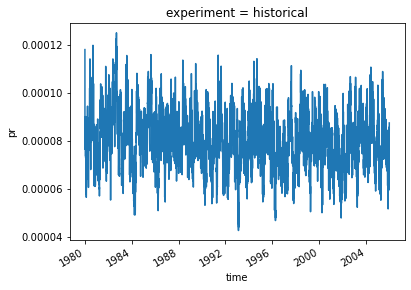

In [51]:
data_ds['pr'].plot()

# Import AOI

In [67]:
DataDir = Path('/home/c4ubuntu/projDir/Indonesia/Data/')

In [623]:
os.listdir(DataDir/'AOI')

['South_Sulawesi.shx',
 'South_Sulawesi.shp',
 'South_Sulawesi.prj',
 'South_Sulawesi.dbf',
 'South_Sulawesi.cpg',
 'NTT_Province.shx',
 'NTT_Province.shp',
 'NTT_Province.prj',
 'NTT_Province.dbf',
 'NTT_Province.cpg']

In [624]:
aoi_01 = gpd.read_file(DataDir/'AOI/South_Sulawesi.shp')
aoi_02 = gpd.read_file(DataDir/'AOI/NTT_Province.shp')

indo_aoi = gpd.GeoDataFrame(pd.concat([aoi_01,aoi_02]))

2022-11-09 08:56:03,762 ERROR PROJ: proj_identify: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2022-11-09 08:56:03,824 INFO Failed to auto identify EPSG: 7
2022-11-09 08:56:04,305 ERROR PROJ: proj_identify: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2022-11-09 08:56:04,346 INFO Failed to auto identify EPSG: 7


In [625]:
indo_aoi = indo_aoi.to_crs(epsg=3857)

<AxesSubplot:>

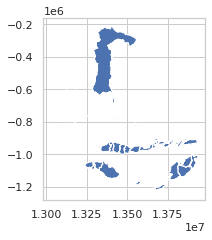

In [626]:
fig, ax = plt.subplots()


indo_aoi.plot(ax = ax)

# Historical climatology for reference period 1980 - 2005

In [52]:
ds_1980_2005_historical = data_ds

# Precipitation

In [69]:
test = ds_1980_2005_historical.pr.to_dataframe()

In [70]:
test

pr
experiment time                         
historical 1980-01-01 12:00:00  0.000118
           1980-01-02 12:00:00  0.000088
           1980-01-03 12:00:00  0.000092
           1980-01-04 12:00:00  0.000094
           1980-01-05 12:00:00  0.000090
...                                  ...
           2005-12-27 12:00:00  0.000076
           2005-12-28 12:00:00  0.000077
           2005-12-29 12:00:00  0.000079
           2005-12-30 12:00:00  0.000085
           2005-12-31 12:00:00  0.000088

[9497 rows x 1 columns]

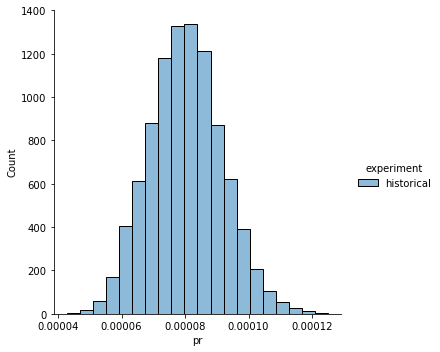

In [71]:
sns.displot(test, x="pr", bins=20, hue='experiment')

#### Monthly mean rainfall

In [32]:
ds_1980_2005_historical = data_ds

In [53]:
precip = ds_1980_2005_historical.pr

In [54]:
precip

<xarray.DataArray 'pr' (experiment: 1, time: 9497)>
dask.array<mean_agg-aggregate, shape=(1, 9497), dtype=float64, chunksize=(1, 1827), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01T12:00:00 ... 2005-12-31T12:0...
  * experiment  (experiment) object 'historical'

In [75]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import NullFormatter

In [76]:
precip.groupby('time.month').mean().month

<xarray.DataArray 'month' (month: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

/tmp/ipykernel_222494/2458460456.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)


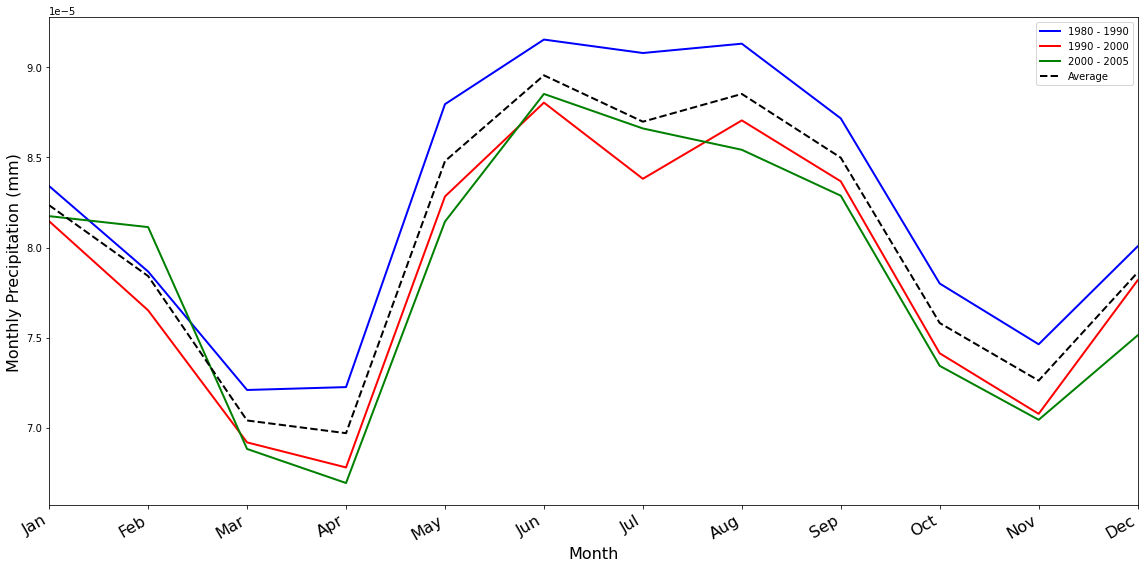

In [77]:
fig, ax = plt.subplots(1, 1 , figsize=(16,8))

precip.sel(time=slice("1980", "1990")).groupby('time.month').mean().plot(ax=ax, color='b', linewidth=2, label='1980 - 1990')
precip.sel(time=slice("1990", "2000")).groupby('time.month').mean().plot(ax=ax,  color='r', linewidth=2, label='1990 - 2000')
precip.sel(time=slice("2000", "2005")).groupby('time.month').mean().plot(ax=ax,  color='g', linewidth=2, label='2000 - 2005')
precip.groupby('time.month').mean().plot(ax=ax,  color='black', linewidth=2, linestyle= 'dashed', label='Average')

ax.legend()
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Monthly Precipitation (mm)', fontsize=16)

fig.autofmt_xdate()


plt.title('')
plt.xlim(1, 12)
plt.locator_params(axis='x', nbins=12)
ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)
plt.tight_layout()

plt.savefig('MonthlyPrecip.png', dpi=300)

#### Annual precipitation anomaly

In [55]:
ann_precip = precip.groupby('time.year').mean()
ann_clim = ann_precip.mean()
ann_anom = ann_precip - ann_clim

In [56]:
df = ann_anom.to_dataframe()
df['positive'] = df['pr'] > 0
df['Rolling'] = df['pr'].rolling(5).mean()
df.reset_index(inplace=True)
df.head() # show only first five rows

,experiment,year,pr,positive,Rolling
0,historical,1980,1.863025e-06,True,NaN
1,historical,1981,6.706557e-07,True,NaN
2,historical,1982,1.124665e-05,True,NaN
3,historical,1983,4.303897e-06,True,NaN
4,historical,1984,-1.123107e-06,False,0.000003


In [57]:
df['positive'] = df['positive'].astype(str)

In [58]:
df['positive'] = df['positive'].str.replace('True','Positive')
df['positive'] = df['positive'].str.replace('False','Negative')

In [59]:
df.rename(columns={'positive':'Anomaly'}, inplace=True)

In [60]:
from altair_saver import save
#df.reset_index(inplace=True)

bar = alt.Chart(df).mark_bar().encode(
    x="year:O",
    y="pr:Q",
    color='Anomaly:N').properties(width=600).encode(x=alt.X('year:O', axis=alt.Axis(title='Year',titleFontSize=15, labelFontSize=12)),
                              y=alt.Y('pr:Q', axis=alt.Axis(title='Mean Precipitation Flux (kg m-2 s-1)', titleFontSize=15, labelFontSize=12)))

line = alt.Chart(df).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(pr)',
    # The number of values before and after the current value to include.
    frame=[-9, 0]
).encode(
    x='year:O',
    y='rolling_mean:Q')

(bar + line).properties(width=100, height=400)

alt.LayerChart(...)

#### Monthly precipitation anomalies

In [86]:
month_precip = precip.resample(time='1M').mean()

In [87]:
month_precip = precip.resample(time='1M').mean()
month_clim = month_precip.mean()
month_anom = month_precip - month_clim

In [88]:
m_precip = month_anom.to_dataframe()
m_precip['positive'] = m_precip['pr'] > 0
m_precip['Rolling'] = m_precip['pr'].rolling(5).mean()
m_precip.reset_index(inplace=True)
m_precip['time'] = pd.to_datetime(m_precip['time'])
m_precip.head() # show only first five rows

,experiment,time,pr,positive,Rolling
0,historical,1980-01-31,0.000004,True,NaN
1,historical,1980-02-29,-0.000006,False,NaN
2,historical,1980-03-31,-0.000002,False,NaN
3,historical,1980-04-30,-0.000011,False,NaN
4,historical,1980-05-31,0.000006,True,-0.000002


In [89]:
m_precip['year'] = m_precip['time'].dt.year

In [90]:
m_precip['month'] = m_precip['time'].dt.month_name()

In [91]:
m_precip = m_precip[['pr','year','month']]

In [92]:
m_precip_anom = m_precip.pivot_table(columns='year',index='month',values='pr')

In [93]:
m_precip_anom = m_precip_anom[[1980,1985,1990,
            1995,2000,2005]]

In [94]:
m_precip_anom = m_precip_anom.reindex(([ 'January','February','March','April', 'May','June','July','August' ,'September','October', 'November','December']))

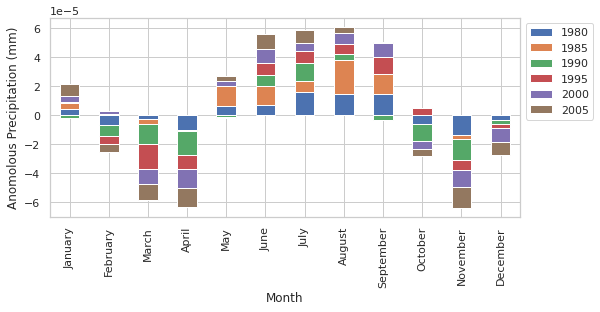

In [95]:
#set seaborn plotting aesthetics
plt.rcParams["figure.figsize"] = [8.50, 4.5]
plt.rcParams["figure.autolayout"] = True
sns.set(style='whitegrid')

#create stacked bar chart
m_precip_anom.plot(kind='bar', stacked=True)

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ylabel('Anomolous Precipitation (mm)')
plt.xlabel('Month')

plt.tight_layout()

# Temperature

#### List

In [96]:
cordx_nc = list()
cordx_nc_rel = glob(f'{DATADIR}tas_*.nc')
for i in cordx_nc_rel:
    cordx_nc.append(os.path.basename(i))

In [97]:
cordx_nc

['tas_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20000101-20041231.nc',
 'tas_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19850101-19891231.nc',
 'tas_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_20050101-20051231.nc',
 'tas_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19800101-19841231.nc',
 'tas_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19950101-19991231.nc',
 'tas_SEA-22_ICHEC-EC-EARTH_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19900101-19941231.nc',
 'tas_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19900101-19941230.nc',
 'tas_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19800101-19841230.nc',
 'tas_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19950101-19991230.nc',
 'tas_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4_day_19850101-19891230.nc',
 'tas_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_RU-CORE-RegCM4-3_v4

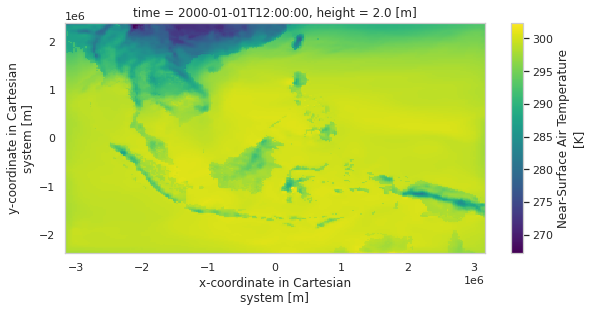

In [98]:
ds = xr.open_dataset(f'{DATADIR}{cordx_nc[0]}')
ds

ds.tas[0].plot()

#### Aggregate

In [552]:
# Function to aggregate in geographical lat lon dimensions
def geog_agg(fn):
    ds = xr.open_dataset(f'{DATADIR}{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['driving_model_id']
    da = ds['tas']
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['y', 'x'])
    da_yr = da_agg
    da_yr = da_yr - 273.15
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}cordex_tas_day_agg_{exp}_{mod}_{str(da_yr.time[0].values)}.nc')

In [553]:
for i in cordx_nc:
    try:
        geog_agg(i)
    except: print(f'{i} failed')

In [646]:
glob(f'{DATADIR}cordex_tas_day_agg_*.nc')

['/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_2000-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_1985-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_2005-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_1980-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_1995-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_ICHEC-EC-EARTH_1990-01-01T12:00:00.000000000.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_MOHC-HadGEM2-ES_1990-01-01 12:00:00.nc',
 '/home/c4ubuntu/projDir/Indonesia/Data/CORDEX/cordex_tas_day_agg_historical_MOHC-HadGEM2-ES_1980-01-01 12:00:00.nc',
 '

In [99]:
temp_ds = xr.open_mfdataset(glob(f'{DATADIR}cordex_tas_day_agg_*01T12*.nc'))

In [100]:
temp_ds = temp_ds.mean(dim='model')

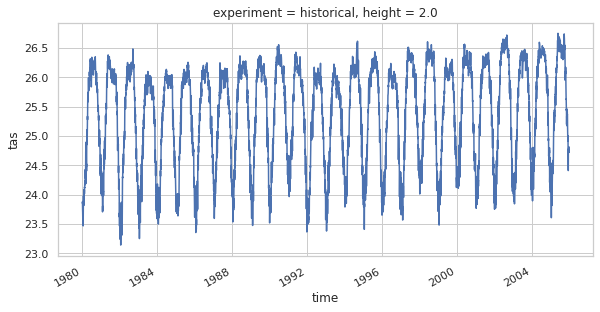

In [101]:
temp_ds.tas.plot()

#### Monthly mean temperature

In [102]:
temp = temp_ds.tas

/tmp/ipykernel_222494/2403441770.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)


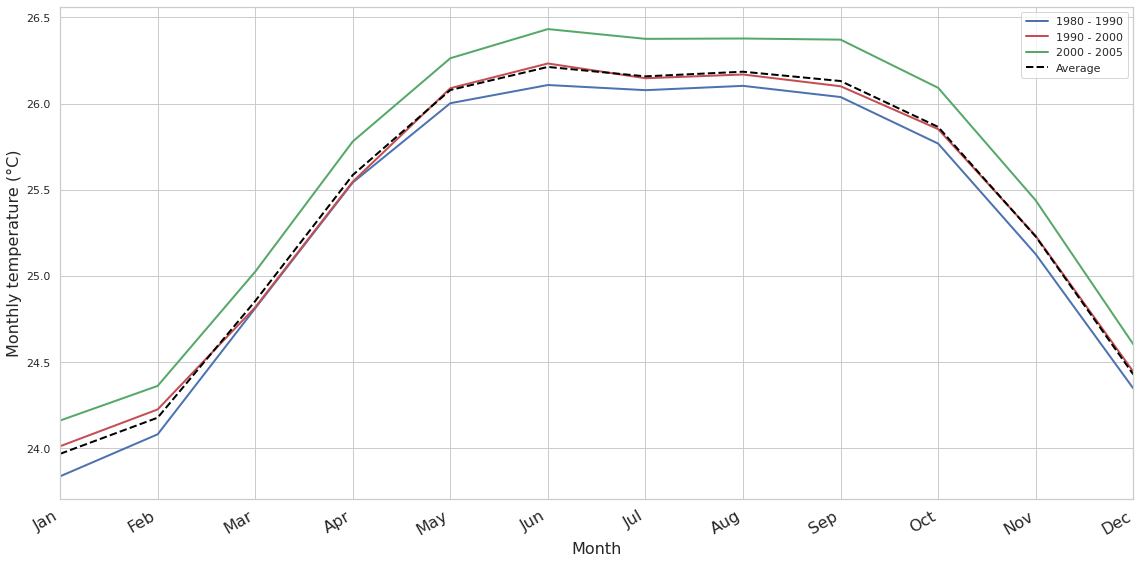

In [103]:

fig, ax = plt.subplots(1, 1 , figsize = (16, 8))

temp.sel(time=slice("1980", "1990")).groupby('time.month').mean().plot(ax=ax, color='b', linewidth=2, label='1980 - 1990')
temp.sel(time=slice("1990", "2000")).groupby('time.month').mean().plot(ax=ax,  color='r', linewidth=2, label='1990 - 2000')
temp.sel(time=slice("2000", "2005")).groupby('time.month').mean().plot(ax=ax,  color='g', linewidth=2, label='2000 - 2005')
temp.groupby('time.month').mean().plot(ax=ax,  color='black', linewidth=2, linestyle= 'dashed', label='Average')

ax.legend()
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Monthly temperature (°C)', fontsize=16)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%B')
plt.title('')

plt.xlim(1, 12)
plt.locator_params(axis='x', nbins=12)
ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)

plt.tight_layout()
plt.savefig('MonthlyTemp.png', dpi=300)

#### Annual Temperature Anomalies

In [104]:
ann_temp = temp.groupby('time.year').mean()
temp_clim = ann_temp.mean()
ann_tmp_anom = ann_temp - temp_clim

In [105]:
df_tmp = ann_tmp_anom.to_dataframe()
df_tmp['positive'] = df_tmp['tas'] > 0
df_tmp['Rolling'] = df_tmp['tas'].rolling(5).mean()
df_tmp.reset_index(inplace=True)
df_tmp.head() # show only first five rows

,experiment,year,height,tas,positive,Rolling
0,historical,1980,2.0,-0.049754,False,NaN
1,historical,1981,2.0,-0.031387,False,NaN
2,historical,1982,2.0,-0.180951,False,NaN
3,historical,1983,2.0,-0.271367,False,NaN
4,historical,1984,2.0,-0.190642,False,-0.14482


In [106]:
df_tmp['positive'] = df_tmp['positive'].astype(str)

df_tmp['positive'] = df_tmp['positive'].str.replace('True','Positive')
df_tmp['positive'] = df_tmp['positive'].str.replace('False','Negative')

df_tmp.rename(columns={'positive':'Anomaly'}, inplace=True)

In [107]:
#df.reset_index(inplace=True)
bar = alt.Chart(df_tmp).mark_bar().encode(
    x="year:O",
    y="tas:Q",
    color='Anomaly:N'
).properties(width=600).encode(x=alt.X('year:O', axis=alt.Axis(title='Year',titleFontSize=15, labelFontSize=12)),
                              y=alt.Y('tas:Q', axis=alt.Axis( title='Mean Temperature (°C)',titleFontSize=15, labelFontSize=12)))

line = alt.Chart(df_tmp).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(tas)',
    # The number of values before and after the current value to include.
    frame=[-9, 0]
).encode(
    x='year:O',
    y='rolling_mean:Q'
)

(bar + line).properties(width=600)

alt.LayerChart(...)

#### Monthly Temperature Anomalies

In [108]:
month_temp = temp.resample(time='1M').mean()

month_temp = temp.resample(time='1M').mean()
month_clim = month_temp.mean()
month_anom = month_temp - month_clim

m_temp = month_anom.to_dataframe()
m_temp['positive'] = m_temp['tas'] > 0
m_temp['Rolling'] = m_temp['tas'].rolling(5).mean()
m_temp.reset_index(inplace=True)
m_temp['time'] = pd.to_datetime(m_temp['time'])
m_temp.head() # show only first five rows

,experiment,time,height,tas,positive,Rolling
0,historical,1980-01-31,2.0,-1.613043,False,NaN
1,historical,1980-02-29,2.0,-1.247007,False,NaN
2,historical,1980-03-31,2.0,-0.762482,False,NaN
3,historical,1980-04-30,2.0,0.101174,True,NaN
4,historical,1980-05-31,2.0,0.606482,True,-0.582975


In [109]:
m_temp['year'] = m_temp['time'].dt.year

m_temp['month'] = m_temp['time'].dt.month_name()

m_temp = m_temp[['tas','year','month']]

m_temp_anom = m_temp.pivot_table(columns='year',index='month',values='tas')

m_temp_anom = m_temp_anom[[1980,1985,1990,
            1995,2000,2005]]

In [110]:
m_temp_anom = m_temp_anom.reindex(([ 'January','February','March','April', 'May','June','July','August' ,'September','October', 'November','December']))

Text(0.5, 0, 'Month')

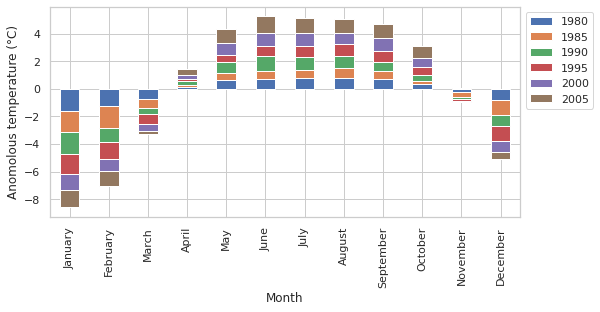

In [111]:
#set seaborn plotting aesthetics
plt.rcParams["figure.figsize"] = [8.5, 4.50]
plt.rcParams["figure.autolayout"] = True
sns.set(style='whitegrid')

#create stacked bar chart
m_temp_anom.plot(kind='bar', stacked=True)

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ylabel('Anomolous temperature (°C)')
plt.xlabel('Month')

# ENSO

In [55]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from pythia_datasets import DATASETS
import cftime

In [4]:
filepath = DATASETS.fetch('CESM2_sst_data.nc')
data = xr.open_dataset(filepath)
filepath2 = DATASETS.fetch('CESM2_grid_variables.nc')
areacello = xr.open_dataset(filepath2).areacello

ds = xr.merge([data, areacello])
ds

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    tos        (time, lat, lon) float32 ...
    areacello  (lat, lon) float64 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

In [5]:
tos_nino34 = ds.where(
    (ds.lat < 5) & (ds.lat > -5) & (ds.lon > 190) & (ds.lon < 240), drop=True
)
tos_nino34

<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 10, lon: 50)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 190.5 191.5 192.5 193.5 ... 236.5 237.5 238.5 239.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2, lat, lon) object 2000-01-01 00:00:00 ... 2015-01-01...
    lat_bnds   (lat, d2, lon) float64 -5.0 -5.0 -5.0 -5.0 ... 5.0 5.0 5.0 5.0
    lon_bnds   (lon, d2, lat) float64 190.0 190.0 190.0 ... 240.0 240.0 240.0
    tos        (time, lat, lon) float32 28.26 28.16 28.06 ... 28.54 28.57 28.63
    areacello  (lat, lon) float64 1.233e+10 1.233e+10 ... 1.233e+10 1.233e+10
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

In [21]:
gb = tos_nino34.tos.groupby('time.month')
tos_nino34_anom = gb - gb.mean(dim='time')
index_nino34 = tos_nino34_anom.weighted(tos_nino34.areacello).mean(dim=['lat', 'lon'])

In [22]:
index_nino34_rolling_mean = index_nino34.rolling(time=5, center=True).mean()

In [31]:
index_nino34_rolling_mean.to_dataframe()

,month,tos
time,,
2000-01-15 12:00:00,1,NaN
2000-02-14 00:00:00,2,NaN
2000-03-15 12:00:00,3,-0.833998
2000-04-15 00:00:00,4,-0.700284
2000-05-15 12:00:00,5,-0.531837
...,...,...
2014-08-15 12:00:00,8,0.121394
2014-09-15 00:00:00,9,0.346704
2014-10-15 12:00:00,10,0.466456


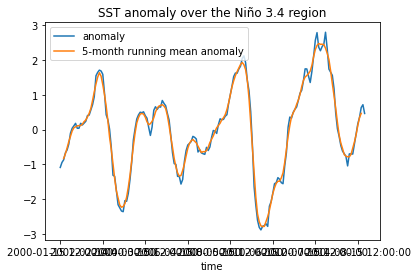

In [34]:
fig, ax = plt.subplots()
index_nino34.to_dataframe()['tos'].plot(ax=ax)
index_nino34_rolling_mean.to_dataframe()['tos'].plot(ax=ax)
plt.legend(['anomaly', '5-month running mean anomaly'])
plt.title('SST anomaly over the Niño 3.4 region');

In [35]:
std_dev = tos_nino34.tos.std()
std_dev

<xarray.DataArray 'tos' ()>
array(1.84363365)

In [40]:
normalized_index_nino34_rolling_mean = index_nino34_rolling_mean / std_dev

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

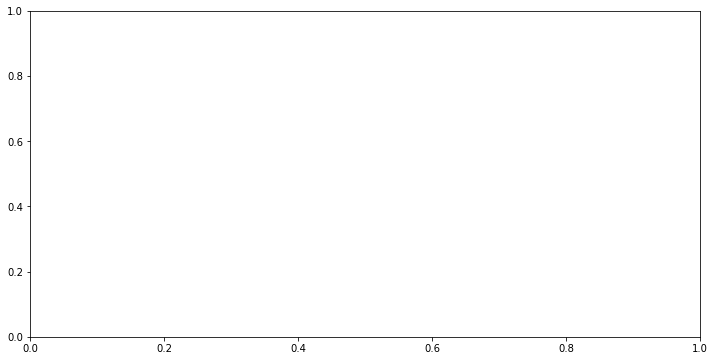

In [42]:
fig = plt.figure(figsize=(12, 6))

plt.fill_between(
    normalized_index_nino34_rolling_mean.time.data,
    normalized_index_nino34_rolling_mean.where(
        normalized_index_nino34_rolling_mean >= 0.4
    ).data,
    0.4,
    color='red',
    alpha=0.9,
)
plt.fill_between(
    normalized_index_nino34_rolling_mean.time.data,
    normalized_index_nino34_rolling_mean.where(
        normalized_index_nino34_rolling_mean <= -0.4
    ).data,
    -0.4,
    color='blue',
    alpha=0.9,
)

normalized_index_nino34_rolling_mean.plot(color='black')
plt.axhline(0, color='black', lw=0.5)
plt.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.title('Niño 3.4 Index');

AttributeError: module '__main__' has no attribute '__file__'